# Toy model

In [1]:
from scipy.special import binom
import numpy as np
import tensornetwork as tn
import tensorflow as tf
from sklearn.model_selection import train_test_split

from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal as mv_norm
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

tn.set_default_backend('tensorflow')
#import tensorflow_datasets as tfds
import os
import json

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

    ####################
def feat_map(x_j, d):
    phi = np.array([np.sqrt(binom(d-1, i - 1))*np.cos(np.pi/2*x_j)**(d-i)*np.sin(np.pi/2*x_j)**(i-1) for i in range(1,d+1)])
    return phi

2022-03-04 13:37:01.430025: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-04 13:37:02.944881: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-04 13:37:02.976455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 13:37:02.976615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-03-04 13:37:02.976643: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-04 13:37:02.980872: I tensorflow/stream_executor/

In [274]:
unit_sq = np.mgrid[0:1:.001, 0:1:.001]

pos = np.dstack(unit_sq)
rv_tL = mv_norm([0., 1.], [[0.1, 0], [0., 0.15]]) #top-Left gaussian
rv_bR = mv_norm([1., 0.], [[0.175, 0], [0., 0.09]]) #bottom-Right gaussian
#Finding the classification bound
dist1 = rv_tL.pdf(pos)
dist2 = rv_bR.pdf(pos)
diff_dist = dist1 - dist2
mask_arr = np.abs(diff_dist) < 1e-4 # Tolerance
zero_line = np.where(mask_arr, dist1, 0)
x_idx, y_idx = np.nonzero(zero_line)
x_vals, y_vals = unit_sq[0,x_idx][:,0], unit_sq[1,:,y_idx][:,0]

#perform quick quadratic fit
def f2(x,a,b,c):
    return a*x**2 + b*x + c

(a_opt, b_opt, c_opt), cov = curve_fit(f2, x_vals, y_vals)
y_est = f2(x_vals, a_opt, b_opt, c_opt)

#Generate samples.
#samples are filtered to be within the unit_square
no_samples = 10000
x1, y1 = rv_tL.rvs(no_samples, random_state=123), np.zeros(no_samples)
x1 = x1[np.array([all([x_1 > 0, x_1 < 1, x_2 > 0, x_2 < 1]) for x_1, x_2 in x1])]
x2, y2 = rv_bR.rvs(no_samples, random_state=123),  np.ones(no_samples)
x2 = x2[np.array([all([x_1 > 0, x_1 < 1, x_2 > 0, x_2 < 1]) for x_1, x_2 in x2])]

#Filter samples to a maximum of 1000 and stack them
max_pts = 1000
x1, y1 = x1[:max_pts], y1[:max_pts]
x2, y2 = x2[:max_pts], y2[:max_pts]
x, y = np.vstack([x1,x2]), np.vstack([y1,y2]).flatten()

#Generate random shuffler for the data
shuffler = np.random.permutation(len(x))
x, y = x[shuffler], y[shuffler]
#shuffle and split data into training and test sets.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=420)

/tmp/ipykernel_14330/1786456434.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


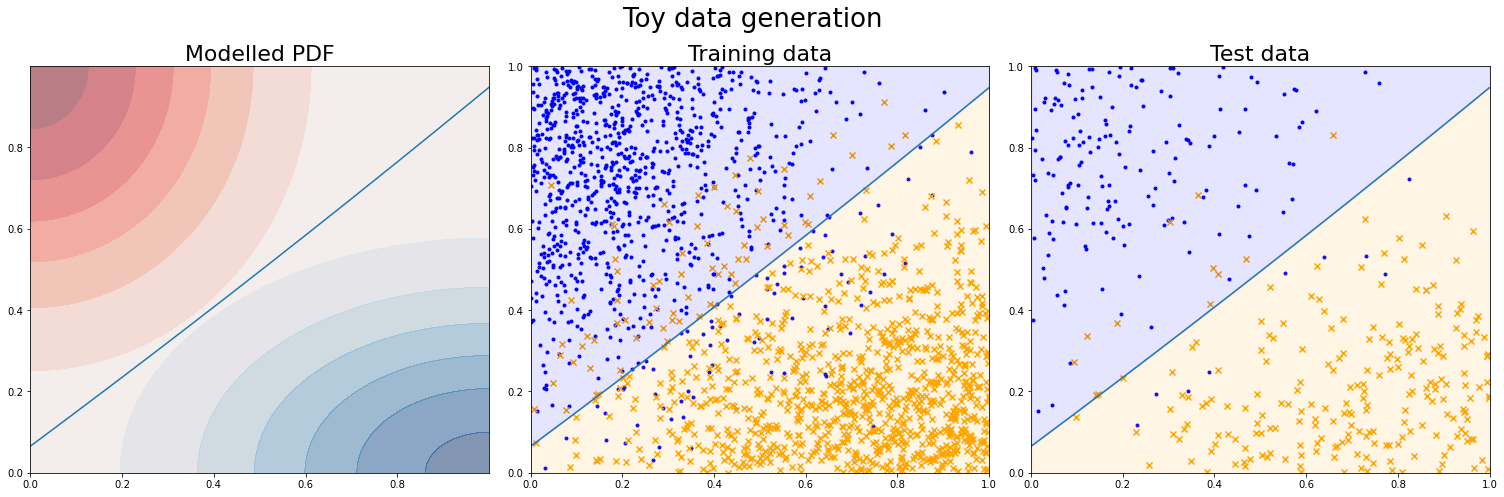

In [275]:
#First plot: the pdfs used to generate data, and the learning bound
fig = plt.figure(figsize=(21,7), tight_layout='pad')
ax1 = fig.add_subplot(131)
ax1.contourf(*unit_sq, rv_tL.pdf(pos), cmap=cm.Reds)
ax1.contourf(*unit_sq, rv_bR.pdf(pos), cmap=cm.Blues, alpha=0.5)
ax1.plot(x_vals, y_est)
ax1.set_title('Modelled PDF', fontsize=22)

#Second plot: training data
ax2 = fig.add_subplot(132)
ax2.scatter(*x1.T, marker='.', color='blue')
ax2.scatter(*x2.T, marker='x', color='orange')
ax2.plot(x_vals, y_est)

ax2.set_title('Training data', fontsize=22)

#Third plot: test data
ax3 = fig.add_subplot(133)
ax3.scatter(*x_test[y_test == 0].T, marker = '.', color = 'blue')
ax3.scatter(*x_test[y_test == 1].T, marker = 'x', color = 'orange')
ax3.plot(x_vals, y_est)
ax3.set_title('Test data', fontsize=22)
fig.suptitle('Toy data generation', fontsize=26)
fig.show()

#Draw the separating plane
for ax in (ax2,ax3):
    ax.fill_between(x_vals, y_est, 0, color='orange', alpha=0.1)
    ax.fill_between(x_vals, y_est, 1, color='blue', alpha= 0.1)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

In [276]:
d=2
#Feature mapping dataset

#square positions in feature map
#This needs some vectorization.
region = unit_sq.T.reshape(1000**2,2)
sq_feat = np.array([np.outer(feat_map(region[i,0], d), feat_map(region[i,1], d)) for i, _ in enumerate(region)])


x_ftrain = np.array([np.outer(feat_map(x_train[i,0], d), feat_map(x_train[i,1], d)) for i, _ in enumerate(x_train)])
x_ftest = np.array([np.outer(feat_map(x_test[i,0], d), feat_map(x_test[i,1], d)) for i, _ in enumerate(x_test)])
#One-hot encode labels
y_htrain, y_htest = tf.one_hot(y_train, 2), tf.one_hot(y_test,2)

In [277]:
class TN_Toy(tf.keras.layers.Layer):
    def __init__(self, d, bond_dim):
        super().__init__()
        self.mps1 = tf.Variable(tf.random.normal((d,bond_dim), stddev = 1/d/bond_dim), trainable=True, name='mps1')
        self.mps2 = tf.Variable(tf.random.normal((d,bond_dim, 2), stddev=1/2/bond_dim/d), trainable=True, name='mps2')
        self.bias = tf.Variable(tf.random.normal((2,), stddev = 1/2), trainable=True, name='bias')

    def call(self, inputs, training=False):
        def f(in_tensor, mps1, mps2, bias):
            x = tn.ncon([in_tensor, mps1, mps2], [[1,2], [1,3], [2,3,-1]])
            return x + bias
        result = tf.vectorized_map(lambda vec: f(vec, self.mps1, self.mps2, self.bias), inputs)
        return tf.nn.softmax(result)


#model instantiation
bond_dim = 4
inputs = tf.keras.Input(shape=(d,d), batch_size=16)
tnet = TN_Toy(d, bond_dim)(inputs)
tnetwork = tf.keras.Model(inputs=inputs, outputs = tnet)
#tnetwork.add(tf.keras.Input(shape=(2,2)))
tnetwork.summary()
tnetwork.compile(optimizer='Adam', loss="binary_crossentropy", metrics = ['accuracy'])

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(16, 2, 2)]              0         
_________________________________________________________________
tn__toy_14 (TN_Toy)          (16, 2)                   26        
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [283]:
tn_history = tnetwork.fit(x_ftrain, y_htrain, validation_split=0.2, epochs=30, verbose=1, shuffle=True)

Epoch 1/30
40/40 [==============================] - 0s 2ms/step - loss: 0.3065 - accuracy: 0.9234 - val_loss: 0.2755 - val_accuracy: 0.9156
Epoch 2/30
40/40 [==============================] - 0s 1ms/step - loss: 0.2822 - accuracy: 0.9227 - val_loss: 0.2534 - val_accuracy: 0.9156
Epoch 3/30
40/40 [==============================] - 0s 1ms/step - loss: 0.2632 - accuracy: 0.9219 - val_loss: 0.2363 - val_accuracy: 0.9156
Epoch 4/30
40/40 [==============================] - 0s 938us/step - loss: 0.2484 - accuracy: 0.9211 - val_loss: 0.2229 - val_accuracy: 0.9156
Epoch 5/30
40/40 [==============================] - 0s 1ms/step - loss: 0.2370 - accuracy: 0.9211 - val_loss: 0.2123 - val_accuracy: 0.9156
Epoch 6/30
40/40 [==============================] - 0s 1ms/step - loss: 0.2280 - accuracy: 0.9195 - val_loss: 0.2040 - val_accuracy: 0.9156
Epoch 7/30
40/40 [==============================] - 0s 1ms/step - loss: 0.2207 - accuracy: 0.9227 - val_loss: 0.1974 - val_accuracy: 0.9156
Epoch 8/30
40/40 [

In [284]:
tnetwork.evaluate(x_ftest, y_htest, batch_size=16)

25/25 [==============================] - 0s 898us/step - loss: 0.1299 - accuracy: 0.9425


[0.12989541888237, 0.9424999952316284]

In [285]:
pred_logits = tnetwork.predict(sq_feat)

pred_labels = np.array([np.argmax(label) for label in pred_logits])

(0.0, 1.0)

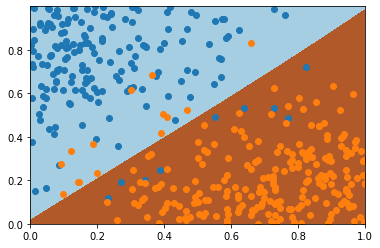

In [286]:
plt.contourf(*unit_sq[::-1], pred_labels.reshape(1000,1000), cmap="Paired")
plt.scatter(*x_test[y_test==0].T, cmap="Paired")
plt.scatter(*x_test[y_test==1].T, cmap="Paired")
plt.xlim(0,1)